# Rank Based Analysis: (535, 536)
Outlier detection method proposed by Barbara. It is based on these steps: 

1. Order the set by rank on occurrences
2. Extract the subset of values that happens `SENSITIVITY` of the time
3. any value outside [ min(subset), max(subset) ] is an outlier 

Sensitivity is set to:

In [57]:
SENSITIVITY = 0.99

In [58]:
from src import *
from src.models.AlmaClasses import *

from pandas import Series
from pandas import DataFrame
from matplotlib import pyplot
import numpy as np

palette = PaletteFileDB(
    filename='../data/processed/colors-almaAntenna.pkl', 
    colorFunction=paintedForAlmaAntennas )

db = DelaysFileDB( 
    caseName="CaseAntennaObserving", 
    path= '../' + config.FILEPATH_DB + "/delays")  

## Pair to study
As a first example we will study this pair:

In [59]:
(a,b) = (535, 536)
# (a, b) = (543, 544)
# (a, b) = (528, 533)

In [60]:
 "C_%s: %s" % (a, palette.getColors()[a])

'C_535: [CONTROL/${ANT}/FrontEnd/IFSwitch - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT}/IFProc_A)'

In [61]:
"C_%s: %s" % (b, palette.getColors()[b])

'C_536: [CONTROL/${ANT}/FrontEnd/IFSwitch - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT}/IFProc_B)'

`pandas.Series` is used below, it allows handy serie manipulation.

In [62]:
delays = Series(db.getDelays(a,b))

In [63]:
delays.describe()

count    4853.000000
mean        7.221306
std         6.029542
min         1.000000
25%         3.000000
50%         6.000000
75%        10.000000
max       214.000000
dtype: float64

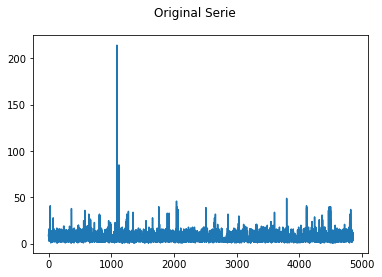

In [64]:
fig = pyplot.figure()
fig.suptitle('Original Serie')
pyplot.plot(delays)
pyplot.show()

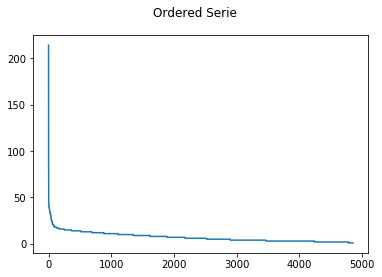

In [65]:
fig = pyplot.figure()
fig.suptitle('Ordered Serie')
# pyplot.yscale('log')
pyplot.plot(sorted(delays, reverse=True))
pyplot.show()

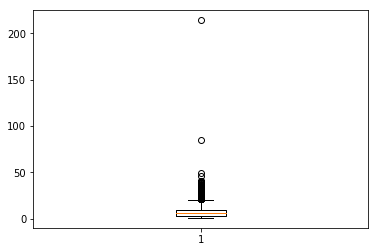

In [66]:
# Simple boxplot
pyplot.boxplot( delays )
pyplot.show()

In [67]:
# DataFrame(delays).boxplot()

## Applying Method
Extracting the rank based on # of occurrences, and make a plot

In [68]:
value_counts = delays.value_counts()

print "Value=%s happens %s times" % (value_counts.index[0], value_counts.values[0])
print "Value=%s happens %s times" % (value_counts.index[1], value_counts.values[1])
print "Value=%s happens %s times" % (value_counts.index[10], value_counts.values[10])


value_counts

Value=3 happens 776 times
Value=4 happens 568 times
Value=12 happens 190 times


3      776
4      568
2      543
5      378
6      343
7      283
8      275
9      265
10     246
11     224
12     190
13     177
14     148
15     117
16      84
1       70
17      40
18      33
21      11
19      11
20       8
32       6
36       5
24       5
26       4
40       4
23       4
28       3
39       3
25       3
33       3
34       3
27       3
31       3
37       2
41       2
22       2
29       1
49       1
35       1
30       1
38       1
46       1
214      1
85       1
dtype: int64

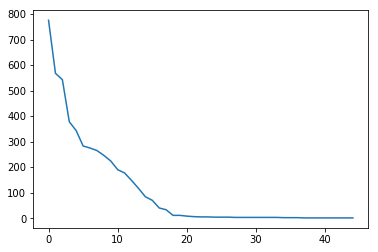

In [69]:
pyplot.plot(value_counts.values)
pyplot.show()

The rank obtained in `value_counts` shows that the evident `outlier=214` happens only 1 time, 41 happens 2 times. Let's see the tail of the ordered original delays: (yes, they are here!)

In [70]:
sorted(delays)[-10:]

[40, 40, 40, 40, 41, 41, 46, 49, 85, 214]

Now, obtain the subset of values that, combined, appears `SENSITIVE` amount of times

In [71]:
# Cumulative sum on value_counts.
cumsum = value_counts.cumsum()

In [72]:
total = cumsum[-1:].values[0]
total

4853

In [73]:
percentageCumsum = cumsum / total

In [74]:
# Note that this method is simpler, but the very explicit results with percentageCumsum is shown for clarity
#typicalValues = cumsum[ cumsum <= SENSITIVITY * total ]

typicalValues = percentageCumsum[ percentageCumsum <= SENSITIVITY]
typicalValues

3     0.159901
4     0.276942
2     0.388832
5     0.466722
6     0.537400
7     0.595714
8     0.652380
9     0.706985
10    0.757676
11    0.803833
12    0.842984
13    0.879456
14    0.909953
15    0.934061
16    0.951370
1     0.965794
17    0.974037
18    0.980837
21    0.983103
19    0.985370
20    0.987018
32    0.988255
36    0.989285
dtype: float64

In [75]:
minVal, maxVal = min(typicalValues.index), max(typicalValues.index)
minVal, maxVal

(1, 36)

# Testing the method
A graph with the "typical" part (minVal < t < maxVal) is shown, with some stats metrics.

In [76]:
typicalDelays = delays[ minVal <= delays ][ delays <= maxVal ]
typicalDelays.describe()

count    4837.000000
mean        7.066363
std         4.810162
min         1.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        36.000000
dtype: float64

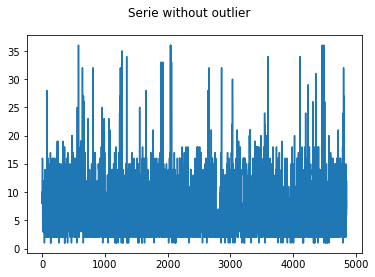

In [77]:
fig = pyplot.figure()
fig.suptitle('Serie without outlier')
pyplot.plot(typicalDelays)
pyplot.show()

Found Outliers:

In [78]:
"%s of %s (%.3f%%)" % ( len(delays) - len(typicalDelays), len(delays), 100*(1.0*len(delays) - len(typicalDelays))/len(delays) )

'16 of 4853 (0.330%)'

In [79]:
delays[ delays < minVal ].values

array([], dtype=int64)

In [80]:
delays[ maxVal < delays ].sort_values().values

array([ 37,  37,  38,  39,  39,  39,  40,  40,  40,  40,  41,  41,  46,
        49,  85, 214])

In [81]:
# All the above in one function
def minmax_rank_based( values, sensitivity ):
    value_counts = Series(delays).value_counts()
    cumsum = value_counts.cumsum()
    typicalValues = cumsum[ cumsum <= sensitivity * value_counts.sum() ]
    return min(typicalValues.index), max(typicalValues.index)

In [82]:
minmax_rank_based( db.getDelays(535,536), SENSITIVITY )

(1, 36)

## Discussion
I believe that the only clear outlier is 214. value=85 seems high in this set, it could be labeled as outlier too. But the other values looks pretty inside a normal range.